In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [53]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics





from keras.models import Sequential 
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')


# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed

In [55]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])
    
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()
    
def testAccuracy(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    predicted_categories = tf.argmax(y_pred, axis=1)
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')
    
def plot_image(pred_array, true_label, img, class_names):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                ),
                                color=color)

def predictions(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 15)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    plt.figure(figsize=(4*num_cols, 2*num_rows))
    for i,index in enumerate(indices):
      plt.subplot(num_rows, num_cols, i+1)
      plot_image(y_pred[index], true_categories[index], images[index],class_names)
    plt.tight_layout()
    plt.show()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("final_model.h5", save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5, restore_best_weights=True
)

In [56]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/vegetable-image-dataset/Vegetable Images/train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/vegetable-image-dataset/Vegetable Images/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/vegetable-image-dataset/Vegetable Images/test", shuffle = False,
)



Loading Train Data...
Found 15000 files belonging to 15 classes.

Loading Validation Data...
Found 3000 files belonging to 15 classes.

Loading Test Data...
Found 3000 files belonging to 15 classes.


In [58]:
class_dirs = os.listdir("../input/vegetable-image-dataset/Vegetable Images/train") # list all directories inside "train" folder

image_dict = {} # dict to store image array(key) for every class(value)

count_dict = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'../input/vegetable-image-dataset/Vegetable Images/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and
    image_dict[cls] = tf.keras.utils.load_img(image_path)

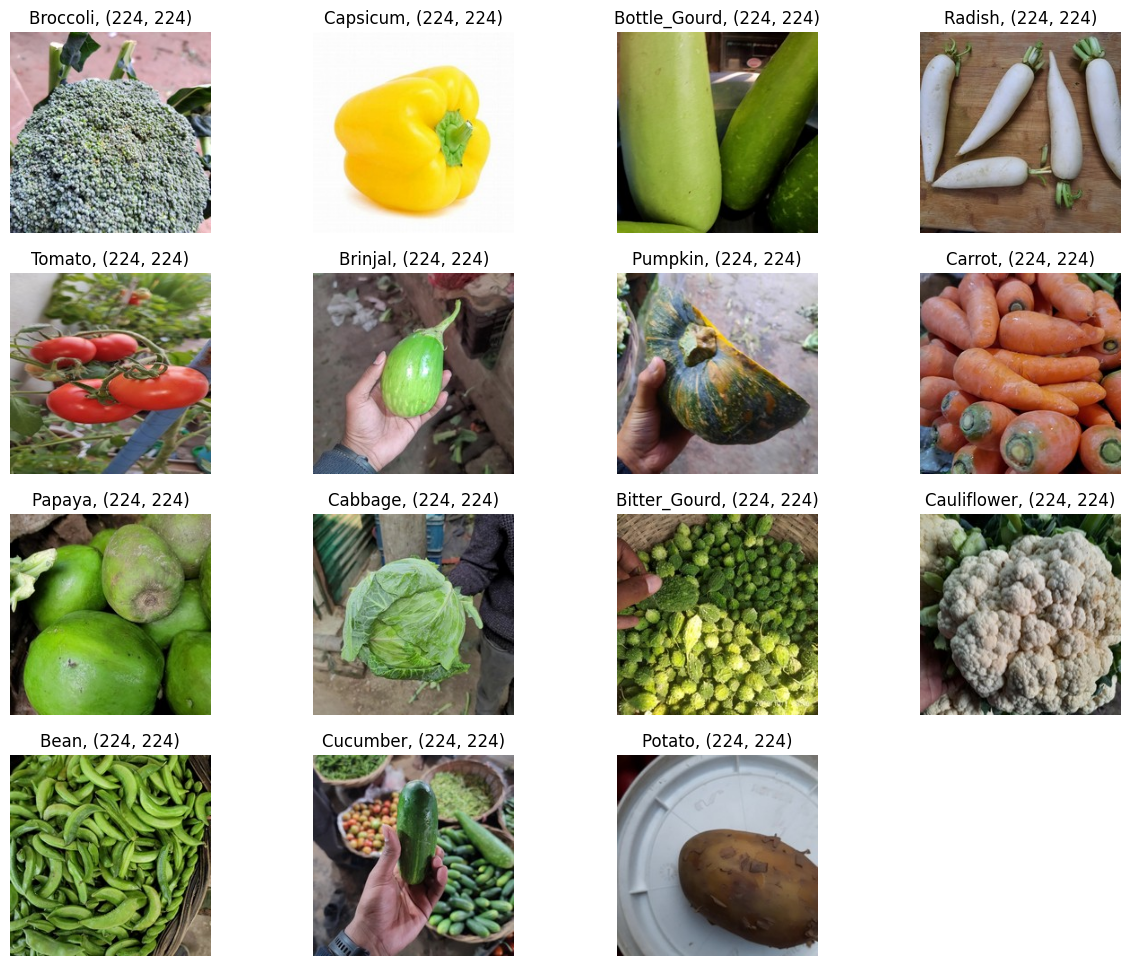

In [59]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    # create a subplot axis
    ax = plt.subplot(4, 4, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

In [61]:
height, width = 224, 224

# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))
num_classes = 15
hidden_size_1 = 1024
hidden_size_2 = 256

In [62]:
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(15, activation='softmax')
])

58889256/58889256 [==============================] - 2s 0us/step


In [63]:
vgg16_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 15)                975       
                                                                 
Total params: 14748495 (56.26 MB)
Trainable params: 33807 (132.06 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [65]:
vgg16_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history_vgg16 = vgg16_model.fit(train_ds, epochs=10, validation_data=val_ds,callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/10
469/469 [==============================] - 41s 83ms/step - loss: 0.0910 - accuracy: 0.9810 - val_loss: 0.1061 - val_accuracy: 0.9737
Epoch 2/10
469/469 [==============================] - 39s 82ms/step - loss: 0.0740 - accuracy: 0.9853 - val_loss: 0.1054 - val_accuracy: 0.9690
Epoch 3/10
469/469 [==============================] - 39s 82ms/step - loss: 0.0610 - accuracy: 0.9881 - val_loss: 0.0762 - val_accuracy: 0.9783
Epoch 4/10
469/469 [==============================] - 39s 83ms/step - loss: 0.0518 - accuracy: 0.9901 - val_loss: 0.0752 - val_accuracy: 0.9787
Epoch 5/10
469/469 [==============================] - 39s 83ms/step - loss: 0.0454 - accuracy: 0.9920 - val_loss: 0.0664 - val_accuracy: 0.9820
Epoch 6/10
469/469 [==============================] - 40s 83ms/step - loss: 0.0394 - accuracy: 0.9931 - val_loss: 0.0678 - val_accuracy: 0.9790
Epoch 7/10
469/469 [==============================] - 39s 82ms/step - loss: 0.0345 - accuracy: 0.9939 - val_loss: 0.0597 - val_accuracy:

In [66]:
testAccuracy(vgg16_model)

94/94 [==============================] - 6s 64ms/step

Test Accuracy: 98.73%



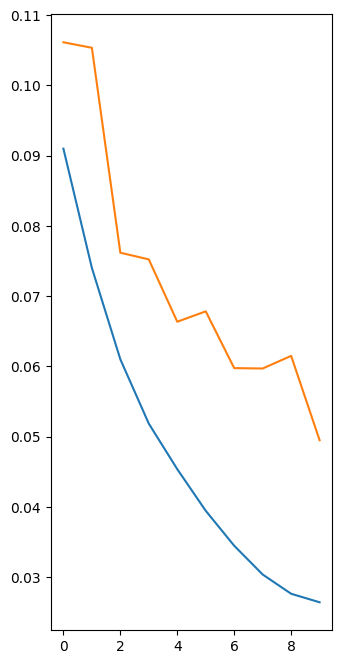

In [75]:
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epoch_range = range(10)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label='Training loss')
plt.plot(epoch_range, val_loss, label='validation loss')

In [76]:
vgg16_model.save("vgg16_model.h5")